 [-----------------100%-----------------] 20000 of 20000 complete in 1.4 sec

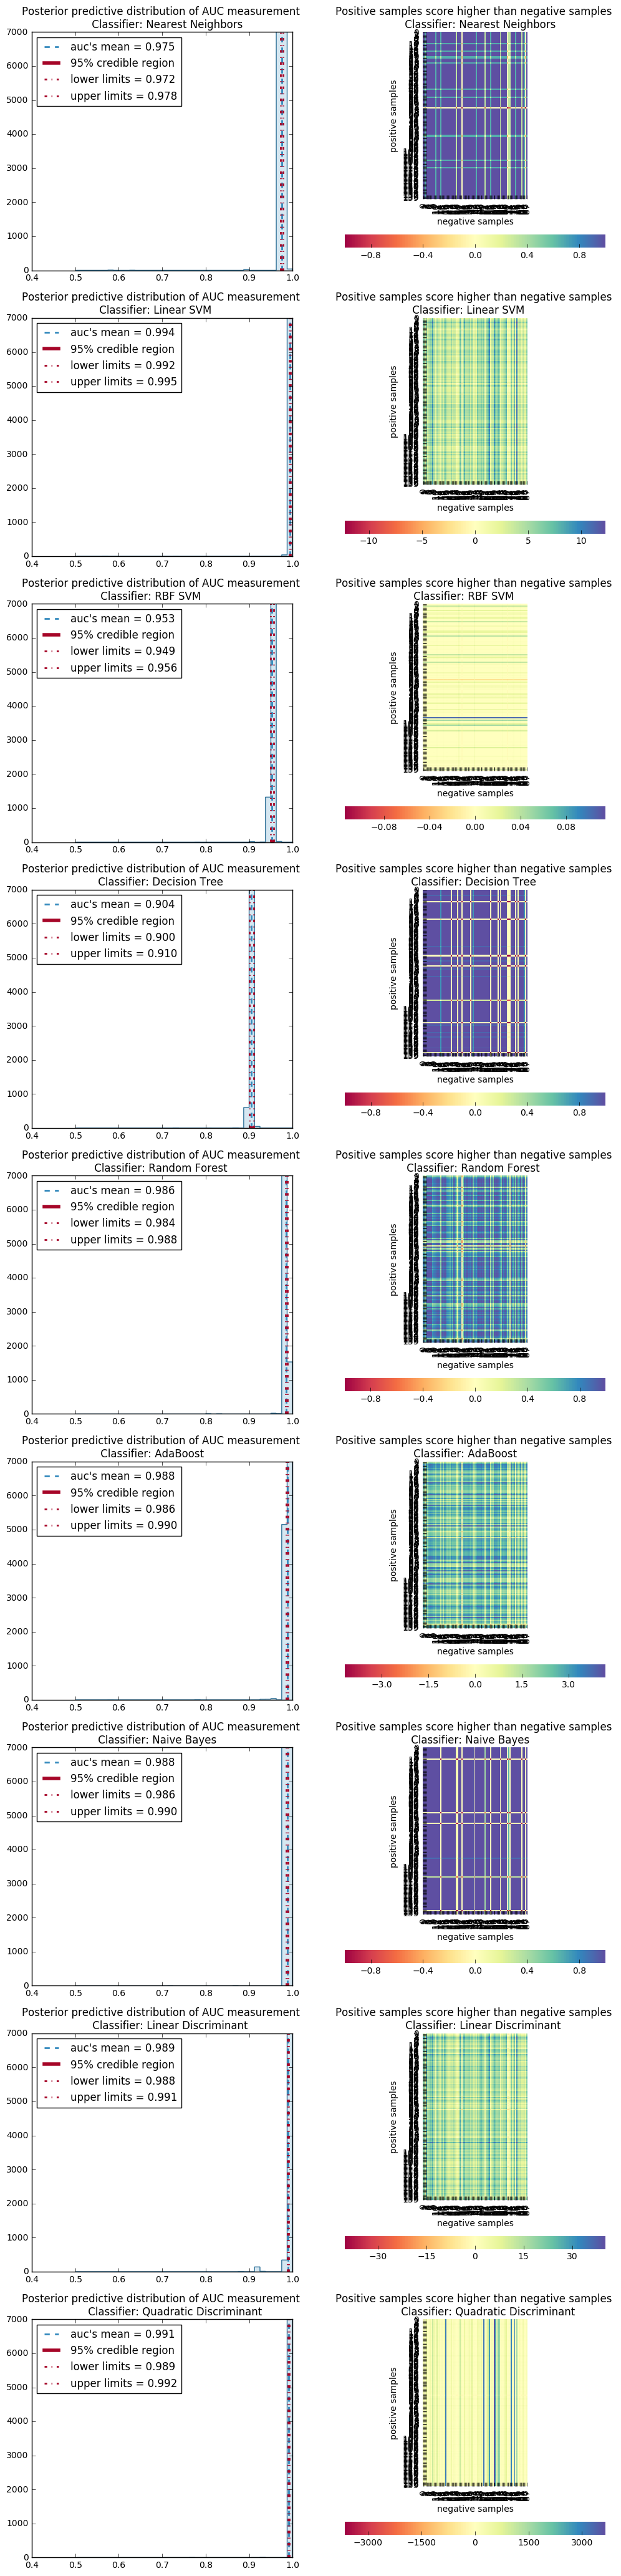

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import itertools
import pandas as pd
import seaborn.apionly as sns
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import rankdata
from sklearn.datasets import load_breast_cancer
%matplotlib inline

colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "AdaBoost", "Naive Bayes", "Linear Discriminant",
         "Quadratic Discriminant"]

# make table pretty
m = len(max(names, key=len))
for name,i in zip(names,range(len(names))):
    padding = ' '*(m-len(name))
    name =name + padding
    names[i]=name

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

summary = pd.DataFrame(columns=['F1_score','AUC_score','Mean','SD','95% HPD'], index=names)

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

# imbalanced dataset
X, y = make_classification(n_features=2, n_redundant=0, n_informative=2, weights=[0.9,0.1],
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
imbalanced = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable,imbalanced]

figure = plt.figure(figsize=(10, 45))
X, y = load_breast_cancer().data, load_breast_cancer().target
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

i = 1
l = len(classifiers)
for name, clf in zip(names, classifiers):
    clf.fit(X_train,y_train)
    if hasattr(clf,"decision_function"):
        y_score = clf.decision_function(X_test)
    else:
        y_score = clf.predict_proba(X_test)[:,1]

    pos_score = y_score[y_test==1]
    neg_score = y_score[y_test==0]
    alldata = np.concatenate((pos_score , neg_score))
    ranked = rankdata(alldata)
    m1 = len(pos_score)
    m2 = len(neg_score)
    pos_rank = ranked[:m1]
    neg_rank = ranked[m1:]
    s = np.sum(pos_rank,axis=0)
    count = s - m1*(m1+1)/2.0

    # Binomal-Beta Conjugate
    n_sample = 20000
    p = pm.Beta("p",alpha=1,beta=1)
    n = pm.Binomial("Bino",n=m1*m2,p=p,value=count,observed=True)
    mcmc = pm.MCMC([n,p])
    trace = mcmc.sample(n_sample)
    auc_trace = mcmc.trace("p")[:]
    auc_mean = auc_trace.mean()
    std = auc_trace.std()

    # 95% credible region
    n_sample = auc_trace.shape[0]
    lower_limits = np.round(np.sort(auc_trace)[int(0.025 * n_sample)],decimals=3)
    upper_limits = np.round(np.sort(auc_trace)[int(0.975 * n_sample)],decimals=3)
    
    summary.ix[name,'F1_score'] = np.round(clf.score(X_test, y_test),decimals=3)
    summary.ix[name,'AUC_score'] =  np.round(roc_auc_score(y_test, y_score),decimals=3)
    summary.ix[name,'Mean'] = np.round(auc_mean,decimals=3)
    summary.ix[name,'SD'] = np.round(std,decimals=3)
    summary.ix[name,'95% HPD'] = (lower_limits,upper_limits)

    # plot Posterior predictive distribution of auc measure
    ax = plt.subplot(l,2,i)
    i += 1
    # from pymc.Matplot import plot as mcplot
    # mcplot(mcmc.trace("p"),common_scale=False)
    _ = ax.hist(auc_trace,range=[0.5, 1.0], bins=40, alpha=.9,
             histtype="step", color=colors[0], 
             label='')
    _hist = ax.hist(auc_trace,range=[0.5, 1.0], bins=40, alpha=.2,
             histtype="stepfilled", color=colors[0] )
    vlines_height = 1.2*np.max(_hist[0])
    _ = ax.vlines(auc_mean,  0.1, vlines_height, label="auc's mean = {0:0.3f}".format(auc_mean),
               linestyles="--", color=colors[0], linewidths=2)
    _ = ax.hlines(0.1, lower_limits, upper_limits, label="95% credible region",
             #  label="95% credible region = {0:0.3f}".format(upper_limits-lower_limits), 
               color=colors[1], linewidths=4)
    _ = ax.vlines(lower_limits,  0.1, vlines_height, label="lower limits = {0:0.3f}".format(lower_limits),
               linestyles="-.", color=colors[1], linewidths=2)
    _ = ax.vlines(upper_limits,  0.1, vlines_height, label="upper limits = {0:0.3f}".format(upper_limits),
               linestyles="-.", color=colors[1], linewidths=2)
    _ = ax.set_title("Posterior predictive distribution of AUC measurement \n \
        Classifier: {0} ".format(name))
    _ = ax.set_ylim([0,7000])
    _ = ax.legend(loc="upper left")

    # Create an empty dataframe
    df = pd.DataFrame(index=range(m1), columns=range(m2), dtype=np.float)

    def prob_score_higher(s_a, s_b):
        return (s_a - s_b)
#         if (s_a - s_b)>0:
#             return 1
#         elif(s_a - s_b)==0:
#             return 0.5
#         else:
#             return 0


    # populate each cell in dataframe with persona_less_personb()
    for a, b in itertools.product(range(m1), range(m2)):
        df.ix[a, b] = prob_score_higher(pos_score[a],neg_score[b])

    ax = plt.subplot(l,2,i)
    i += 1
    cmap = plt.get_cmap("Spectral")
    _ = sns.heatmap(df, square=True,cmap=cmap,cbar_kws={"orientation": "horizontal"})
    _ = ax.set_title("Positive samples score higher than negative samples \n \
        Classifier: {0} ".format(name))
    _ = ax.set_ylabel("positive samples")
    _ = ax.set_xlabel("negative samples")

figure.subplots_adjust(left=.04, right=.96, bottom=.05, top=.95)
plt.show()

In [13]:
from sklearn.cross_validation import cr
parameters = {'C': scipy.stats.expon(scale=100), 'gamma': scipy.stats.expon(scale=.1),
  'kernel': ['rbf'], 'class_weight':['balanced', None]}
gs_clf = GridSearchCV(SVC(), parameters, n_jobs=-1)




ImportError: cannot import name GridSearchCV